## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
!pip install torchvision
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:02<00:00, 11767796.23it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204954.00it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3942943.16it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20350873.70it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            #
            nn.Linear(input_shape, num_classes * 5),
            nn.BatchNorm1d(num_classes * 5),
            nn.ReLU(),
            nn.Dropout1d(p=0.4),
            nn.Linear(num_classes * 5, num_classes * 3),
            nn.BatchNorm1d(num_classes * 3),



            nn.ReLU(),
            nn.Dropout1d(p=0.4),
            nn.Linear(num_classes * 3, num_classes),
            nn.LogSoftmax()



        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
       BatchNorm1d-3                   [-1, 50]             100
              ReLU-4                   [-1, 50]               0
         Dropout1d-5                   [-1, 50]               0
            Linear-6                   [-1, 30]           1,530
       BatchNorm1d-7                   [-1, 30]              60
              ReLU-8                   [-1, 30]               0
         Dropout1d-9                   [-1, 30]               0
           Linear-10                   [-1, 10]             310
       LogSoftmax-11                   [-1, 10]               0
Total params: 41,250
Trainable params: 41,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Your experiments come here:

In [ ]:
from tqdm import tqdm

In [ ]:
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()

epochs = 50

train_losses = []
val_losses = []

pbar = tqdm(range(epochs), desc='Total')
for i in pbar:
    pbar.set_description(
        f'Loss: {0.0 if len(train_losses) == 0 else train_losses[-1]}'
    )

    model.train()
    train_loss_epoch = []
    for X_batch, y_batch in train_loader:
        opt.zero_grad()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        loss.backward()
        opt.step()
        train_loss_epoch.append(loss.item())

    train_losses.append(np.mean(train_loss_epoch))

    model.eval()
    train_loss_epoch = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        train_loss_epoch.append(loss.item())

    val_losses.append(np.mean(train_loss_epoch))

Loss: 1.5347252499574282: 100%|██████████| 50/50 [07:54<00:00,  9.48s/it]


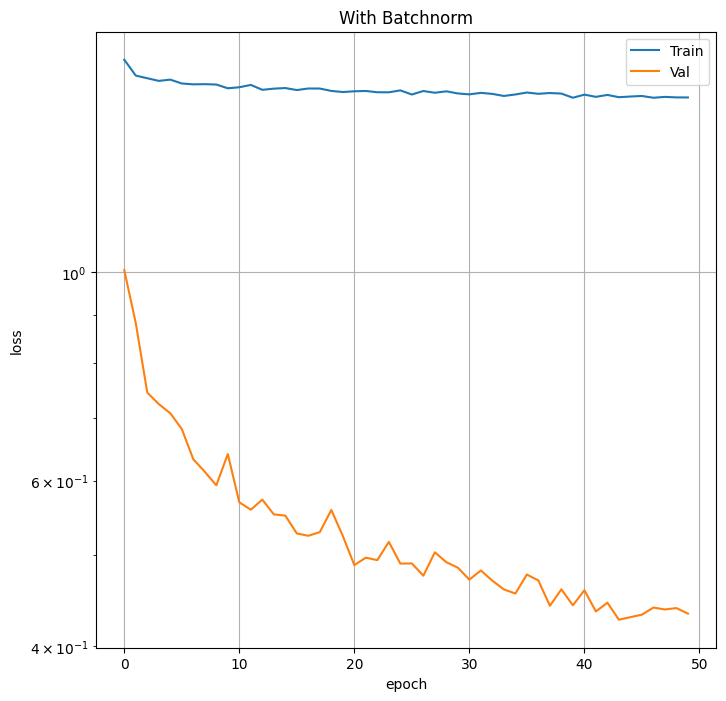

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
plt.title('Batchnorm')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('logs')
plt.plot(range(epochs), torch.Tensor(train_losses), label='train')
plt.plot(range(epochs), torch.Tensor(val_losses), label='validation')
plt.grid()
plt.legend()

In [ ]:
test_accuracy = 0.0
target, total = 0, 0
for X_batch, y_batch in test_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    probs = model(X_batch)
    preds = probs.argmax(axis=1)
    target += (preds == y_batch).sum().item()
    total += len(y_batch)
test_accuracy = target / total
print('Accuracy:', test_accuracy)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy: 0.8766


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Here we can try just remove dropout and batchnormalization, increase number of neurons in hidden layers and increase the number of this layers.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, num_classes * 15),
            nn.ReLU(),
            nn.Linear(num_classes * 15, num_classes * 15),
            nn.ReLU(),
            nn.Linear(num_classes * 15, num_classes * 15),
            nn.ReLU(),
            nn.Linear(num_classes * 15, num_classes * 15),
            nn.ReLU(),
            nn.Linear(num_classes * 15, num_classes * 15),
            nn.ReLU(),
            nn.Linear(num_classes * 15, num_classes * 15),
            nn.ReLU(),
            nn.Linear(num_classes * 15, num_classes * 15),
            nn.ReLU(),
            nn.Linear(num_classes * 15, num_classes),
            nn.LogSoftmax()
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 150]         117,750
              ReLU-3                  [-1, 150]               0
            Linear-4                  [-1, 150]          22,650
              ReLU-5                  [-1, 150]               0
            Linear-6                  [-1, 150]          22,650
              ReLU-7                  [-1, 150]               0
            Linear-8                  [-1, 150]          22,650
              ReLU-9                  [-1, 150]               0
           Linear-10                  [-1, 150]          22,650
             ReLU-11                  [-1, 150]               0
           Linear-12                  [-1, 150]          22,650
             ReLU-13                  [-1, 150]               0
           Linear-14                  [

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=3e-3)
loss_func = nn.NLLLoss()

# Your experiments, come here
epochs = 50

train_loss = []
val_loss = []

pbar = tqdm(range(epochs), desc='Total')
for i in pbar:
    model.train()
    train_loss_epoch = []
    for X_batch, y_batch in train_loader:
        opt.zero_grad()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        loss.backward()
        opt.step()
        train_loss_epoch.append(loss.item())
    train_loss.append(np.mean(train_loss_epoch))
    model.eval()
    train_loss_epoch = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        train_loss_epoch.append(loss.item())
    val_loss.append(np.mean(train_loss_epoch))

Total: 100%|██████████| 50/50 [07:55<00:00,  9.51s/it]


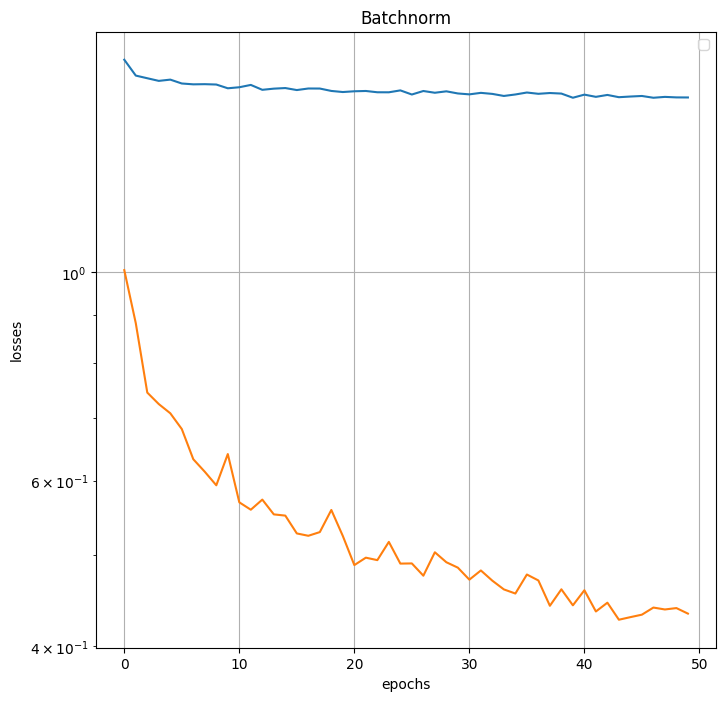

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plt.title('Batchnorm')

plt.xlabel('epochs')
plt.ylabel('losses')
plt.yscale('log')

plt.plot(range(epochs), torch.Tensor(train_losses))
plt.plot(range(epochs), torch.Tensor(val_losses))
plt.grid()
plt.legend()

In [ ]:
test_accuracy = 0.0
correct, total = 0, 0
for X_batch, y_batch in train_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    probs = model(X_batch)
    preds = probs.argmax(axis=1)
    correct += (preds == y_batch).sum().item()
    total += len(y_batch)
train_accuracy = correct / total
print('Accuracy:', train_accuracy)

Accuracy: 0.9321333333333334


In [ ]:
test_accuracy = 0.0
correct, total = 0, 0
for X_batch, y_batch in test_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    probs = model(X_batch)
    preds = probs.argmax(axis=1)
    correct += (preds == y_batch).sum().item()
    total += len(y_batch)
test_accuracy = correct / total
print('Accuracy:', test_accuracy)

Accuracy: 0.882


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, num_classes * 20),
            nn.BatchNorm1d(num_classes * 20),
            nn.ReLU(),



            nn.Dropout1d(p=0.5),
            nn.Linear(num_classes * 20, num_classes * 20),
            nn.BatchNorm1d(num_classes * 20),
            nn.ReLU(),
            nn.Dropout1d(p=0.5),
            nn.Linear(num_classes * 20, num_classes * 20),
            nn.BatchNorm1d(num_classes * 20),
            nn.ReLU(),
            nn.Dropout1d(p=0.5),
            nn.Linear(num_classes * 20, num_classes * 20),
            nn.BatchNorm1d(num_classes * 20),
            nn.ReLU(),
            nn.Dropout1d(p=0.5),
            nn.Linear(num_classes * 20, num_classes),
            nn.LogSoftmax()
        )
    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=3e-3) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE

# Your experiments, come here
epochs = 50

train_losses = [] # for each epoch
val_losses = [] # for each epoch

pbar = tqdm(range(epochs), desc='Total')
for i in pbar:
    pbar.set_description(
        f'Loss: {0.0 if len(train_losses) == 0 else train_losses[-1]}'
    )

    model.train()
    train_loss_epoch = []
    for X_batch, y_batch in train_loader:
        opt.zero_grad()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        loss.backward()
        opt.step()
        train_loss_epoch.append(loss.item())

    train_losses.append(np.mean(train_loss_epoch))

    model.eval()
    train_loss_epoch = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        train_loss_epoch.append(loss.item())

    val_losses.append(np.mean(train_loss_epoch))

Loss: 2.1816915184704224: 100%|██████████| 50/50 [08:00<00:00,  9.62s/it]


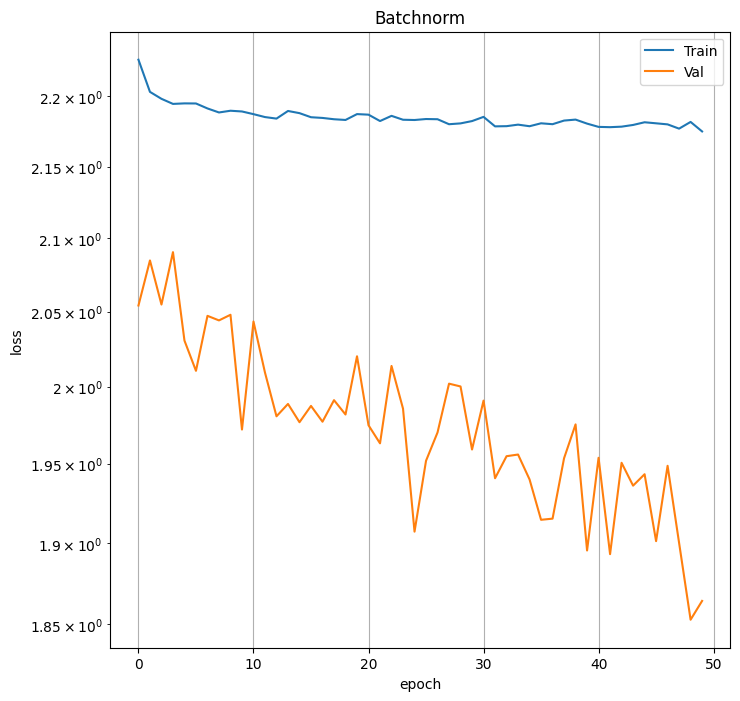

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
plt.title('Batchnorm')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.plot(range(epochs), torch.Tensor(train_losses), label='Train')
plt.plot(range(epochs), torch.Tensor(val_losses), label='Val')
plt.grid()
plt.legend()

In [ ]:
test_accuracy = 0.0
correct, total = 0, 0
for X_batch, y_batch in train_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    probs = model(X_batch)
    preds = probs.argmax(axis=1)
    correct += (preds == y_batch).sum().item()
    total += len(y_batch)
train_accuracy = correct / total
print('Accuracy:', train_accuracy)

Accuracy: 0.8791666666666667


In [ ]:
test_accuracy = 0.0
correct, total = 0, 0
for X_batch, y_batch in test_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    probs = model(X_batch)
    preds = probs.argmax(axis=1)
    correct += (preds == y_batch).sum().item()
    total += len(y_batch)
test_accuracy = correct / total
print('Accuracy:', test_accuracy)

Accuracy: 0.8546
